Данные взял изначальные без предобработки, т.к. на них скор получается лучше. Видимо из-за того, что во время предобработки теряется много данных.

Так же тут отражен только последний шаг, который привел к лучшему скору. До этого были различные попытки обработки данных.

In [1]:
# библиотеки, ворнинги
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
import shap
from phik.report import plot_correlation_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
# стили
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

In [3]:
# данные
test_for_sub = pd.read_csv('C:/Users/Vladimir/Desktop/cSV/leopard challendge/test.csv')
df = pd.read_csv('C:/Users\Vladimir/Desktop/cSV/leopard challendge/train.csv')

In [4]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [5]:
test_for_sub.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', 'Date',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [6]:
# возьмём небольшую часть данных, чтобы оценить влияние по Фику
df_exp = df.sample(frac=0.05, random_state=42)
phik_overview = df_exp.phik_matrix()

interval columns not set, guessing: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'id']


In [7]:
# смотрим зависимоть по Фику
phik_overview['Price'].sort_values(ascending=False)

Address          1.000000
Price            1.000000
BuildingArea     0.696160
CouncilArea      0.508622
Type             0.488028
Bathroom         0.464978
YearBuilt        0.415987
Suburb           0.415610
Rooms            0.404530
Bedroom2         0.375137
Regionname       0.326648
SellerG          0.319844
Method           0.284778
Car              0.280614
Lattitude        0.274031
Postcode         0.271711
Propertycount    0.266345
Longtitude       0.232429
id               0.077716
Distance         0.000000
Date             0.000000
Landsize         0.000000
Name: Price, dtype: float64

In [8]:
# посмотрю пропуски в наиболее влиятельных по мнению фика фичах
df[['Address', 'BuildingArea', 'CouncilArea']].isna().sum()

Address             0
BuildingArea    10623
CouncilArea         1
dtype: int64

In [9]:
# предобработаю CouncilArea
df[df['CouncilArea'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
14406,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21235


In [10]:
df[df['Suburb'] == 'Footscray'].sample(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
13611,Footscray,8/5 Saltriver Pl,3,t,800000.0,S,Village,8/07/2017,5.1,3011.0,3.0,2.0,2.0,0.0,NaN,NaN,Maribyrnong City Council,-37.80196,144.90783,Western Metropolitan,7570.0,29609
3406,Footscray,6 John St,4,h,1100000.0,SP,Biggin,13/08/2016,6.4,3011.0,3.0,1.0,2.0,633.0,NaN,NaN,Maribyrnong City Council,-37.80200,144.88900,Western Metropolitan,7570.0,32677
3417,Footscray,45 Droop St,3,h,1045000.0,S,Sweeney,16/07/2016,6.4,3011.0,3.0,2.0,2.0,384.0,NaN,NaN,Maribyrnong City Council,-37.79760,144.89760,Western Metropolitan,7570.0,23019
3383,Footscray,6/114 Commercial Rd,1,u,291000.0,PI,Sweeney,7/05/2016,6.4,3011.0,1.0,1.0,1.0,665.0,46.0,1970.0,Maribyrnong City Council,-37.79780,144.89180,Western Metropolitan,7570.0,29380
3450,Footscray,10/24 Eldridge St,2,u,316000.0,S,Burnham,27/06/2016,6.4,3011.0,2.0,1.0,1.0,0.0,55.0,1960.0,Maribyrnong City Council,-37.78900,144.89320,Western Metropolitan,7570.0,18576


In [11]:
t = df[df['Suburb'] == 'Footscray'][['CouncilArea', 'Regionname', 'Propertycount']]

for i in t.columns:
    print(t[i].unique())

['Maribyrnong City Council' nan]
['Western Metropolitan' nan]
[7570.   nan]


Получается у 1 объекта пропущено значение округа. Т.к. это территория, проверил, что у всех объектов совпадают территориальные поля.Заполню их. 

In [12]:
df['CouncilArea'] = df['CouncilArea'].fillna('Maribyrnong City Council')
df['Regionname'] = df['Regionname'].fillna('Western Metropolitan')
df['Propertycount'] = df['Propertycount'].fillna(7570.0)

In [13]:
# дам медианное значение пропускам по площади объекта
df['BuildingArea'] = df['BuildingArea'].fillna(np.median(df['BuildingArea']))

In [14]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname']
y = ['Price']
cat_features = ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']

In [15]:
# разобью тренировочную выборку на тренировочную и тестовую
train, test = train_test_split(df, random_state = 42, train_size = 0.6)

In [16]:
# из тестовой выделю данные для валидации
train_val, test = train_test_split(test, random_state=42, train_size=0.5)

In [17]:
# провею
print(round(len(train) / len(df), 1)) 
print(round(len(train_val) / len(df), 1)) 
print(round(len(test) / len(df), 1)) 

0.6
0.2
0.2


In [18]:
# параметры модели
parametrs = {'cat_features': cat_features, 
             'eval_metric': 'MAPE', 
             'verbose': 100, #показывать каждую 100-ю строчку
             'random_seed': 42,
             'learning_rate': 0.1, #скорость обучения модели
             'early_stopping_rounds': 200}

In [19]:
model = CatBoostRegressor(**parametrs)

In [20]:
# обучаю модель. 
model.fit(train[X], train[y], eval_set=(train_val[X], train_val[y]))

0:	learn: 0.5016994	test: 0.4910015	best: 0.4910015 (0)	total: 187ms	remaining: 3m 6s
100:	learn: 0.1744270	test: 0.1710436	best: 0.1710436 (100)	total: 4.38s	remaining: 39s
200:	learn: 0.1587737	test: 0.1612010	best: 0.1612010 (200)	total: 8.74s	remaining: 34.7s
300:	learn: 0.1495077	test: 0.1559319	best: 0.1559319 (300)	total: 13.1s	remaining: 30.4s
400:	learn: 0.1430698	test: 0.1533528	best: 0.1533456 (398)	total: 17.5s	remaining: 26.1s
500:	learn: 0.1374888	test: 0.1518185	best: 0.1517313 (491)	total: 21.8s	remaining: 21.7s
600:	learn: 0.1330056	test: 0.1509838	best: 0.1509837 (598)	total: 26.3s	remaining: 17.4s
700:	learn: 0.1293983	test: 0.1502553	best: 0.1501828 (684)	total: 30.8s	remaining: 13.1s
800:	learn: 0.1262254	test: 0.1494766	best: 0.1494662 (798)	total: 35.2s	remaining: 8.75s
900:	learn: 0.1233483	test: 0.1488985	best: 0.1488985 (900)	total: 39.7s	remaining: 4.36s
999:	learn: 0.1205665	test: 0.1479254	best: 0.1479254 (999)	total: 44s	remaining: 0us

bestTest = 0.147925

In [21]:
# предикт
test['Price_pred'] =  model.predict(test[X])

In [22]:

mean_absolute_percentage_error(test['Price'], test['Price_pred'])

0.1532681574292289

In [23]:
# предобработка категориальных фичей теста
test_for_sub[cat_features].isna().sum()

Suburb         0
Type           0
Method         0
SellerG        0
Date           0
CouncilArea    2
Regionname     2
dtype: int64

In [24]:
test_for_sub[test_for_sub['CouncilArea'].isna()]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
2634,Camberwell,2/3 Kingsley St,2,h,VB,Jellis,11/11/2017,7.7,3124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15921
4628,Fawkner Lot,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262


In [25]:
t = test_for_sub[test_for_sub['Suburb'] == 'Camberwell'][['CouncilArea', 'Regionname', 'Propertycount']]

for i in t.columns:
    print(t[i].unique())

['Boroondara City Council' nan]
['Southern Metropolitan' nan]
[8920.   nan]


In [26]:
t = test_for_sub[test_for_sub['Suburb'] == 'Fawkner Lot'][['CouncilArea', 'Regionname', 'Propertycount']]

for i in t.columns:
    print(t[i].unique())

[nan]
[nan]
[nan]


In [27]:
# по Camberwell заполняю
test_for_sub['CouncilArea'] = test_for_sub['CouncilArea'].fillna('Boroondara City Council')
test_for_sub['Regionname'] = test_for_sub['Regionname'].fillna('Southern Metropolitan')
test_for_sub['Propertycount'] = test_for_sub['Propertycount'].fillna(8920.0)

In [28]:
test_for_sub['Price'] = model.predict(test_for_sub[X])

In [29]:
test_for_sub[['id', 'Price']].to_csv('my_first_score.csv', index=False)

#### Скор на тесте 15.68 =( И это только 83 место. Лучший скор - 13.10

### Проведу анализ ошибок, обучу новую модель. Анализ буду проводить на трейне (на тесте отсутствует стартовый столбец с ценой).

In [30]:
test['error'] = test['Price_pred'] - test['Price']

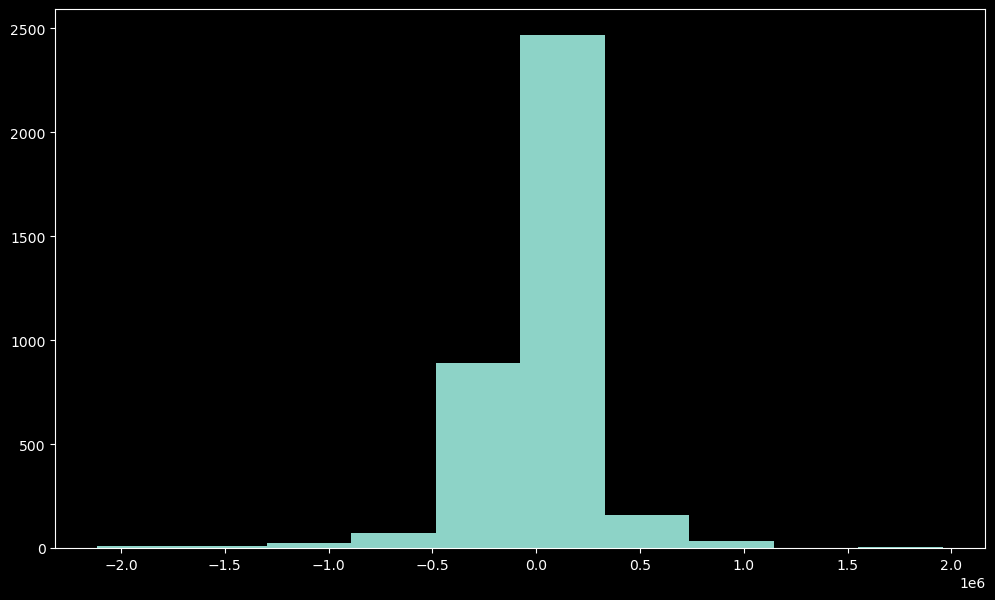

In [31]:
test['error'].hist(bins=10, grid=False, figsize=(12,7))
plt.show()

In [32]:
test['error'].mean()

-3171.2348173692626

В среднем модель занижает.

In [33]:
#абсолютная ошибка
test['error_abs'] = abs(test['error'])

# топ 10 жестких ошибок модели
test.sort_values(by='error_abs', ascending=False).head(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,Price_pred,error,error_abs
5691,Northcote,167 Clarke St,5,h,4300000.0,SP,McGrath,24/09/2016,5.5,3070.0,4.0,4.0,3.0,569.0,NaN,1910.0,Darebin City Council,-37.77630,144.99640,Northern Metropolitan,11364.0,32596,2.187001e+06,-2.112999e+06,2.112999e+06
2205,Canterbury,14 Monomeath Av,5,h,5110000.0,S,Jellis,28/05/2016,9.0,3126.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,3265.0,1317,3.069912e+06,-2.040088e+06,2.040088e+06
8171,Toorak,37 Tintern Av,3,h,5000000.0,VB,Kay,28/05/2016,4.6,3142.0,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,7217.0,4652,2.971673e+06,-2.028327e+06,2.028327e+06
2085,Camberwell,11 Sunnyside Av,3,h,3775000.0,S,Jellis,10/12/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0,31737,1.791559e+06,-1.983441e+06,1.983441e+06
18131,Malvern,7 Northbrook Av,4,h,860000.0,SP,Abercromby's,26/08/2017,5.9,3144.0,4.0,2.0,3.0,633.0,NaN,NaN,Stonnington City Council,-37.85612,145.03273,Southern Metropolitan,4675.0,28771,2.819787e+06,1.959787e+06,1.959787e+06
4847,Malvern,2/5 Moorakyne Av,4,h,1395000.0,S,Marshall,27/11/2016,7.4,3144.0,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,4675.0,3046,3.319280e+06,1.924280e+06,1.924280e+06
4850,Malvern,5 Northbrook Av,4,h,4940000.0,S,Abercromby's,28/08/2016,7.4,3144.0,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,4675.0,28793,3.039668e+06,-1.900332e+06,1.900332e+06
772,Balwyn,1 Prowse Av,6,h,4600000.0,SP,Philip,26/07/2016,9.7,3103.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,5682.0,25265,2.713730e+06,-1.886270e+06,1.886270e+06
5441,Newport,75 The Strand,4,h,3420000.0,PI,RT,22/08/2016,8.4,3015.0,4.0,2.0,2.0,757.0,NaN,1886.0,Hobsons Bay City Council,-37.84900,144.89470,Western Metropolitan,5498.0,14667,1.644443e+06,-1.775557e+06,1.775557e+06
10387,Parkville,21 Morrah St,4,h,3970000.0,S,Collins,13/05/2017,2.6,3052.0,4.0,3.0,1.0,289.0,NaN,NaN,Melbourne City Council,-37.79590,144.95690,Northern Metropolitan,2309.0,14881,2.211813e+06,-1.758187e+06,1.758187e+06


In [35]:
# сгруппирую по цене
test['price_group'] = pd.qcut(test['Price'], 5)

In [36]:
# посмотрю на каких ценовых группах модель ошибается больше
t1 = test.groupby('price_group')[['error_abs', 'error']].agg({'count', 'mean'})
t1 = t1.droplevel(1,axis=1)
t1

,error_abs,error_abs,error,error
price_group,,,,
"(229999.999, 582500.0]",736,83700.902171,736,59524.574668
"(582500.0, 765000.0]",739,91100.807121,739,33339.559867
"(765000.0, 1005000.0]",732,125833.706631,732,33606.440068
"(1005000.0, 1410000.0]",734,164848.769974,734,3040.833336
"(1410000.0, 5110000.0]",734,343226.456185,734,-145686.914781


Больше всего модель ошибается на самых дорогих объектах. Посмотрю как ошибается модель на других фичах.

In [42]:
test['Landsize_gr'] = pd.cut(test['Landsize'], [-1, 100, 500, 1000, 5000])
test['Distance_gr'] = pd.cut(test['Distance'], [-1, 10, 20, 30, 40, 100])
test['Propertycount_gr'] = pd.cut(test['Propertycount'], [-1, 5000, 10000, 15000, 20000, 30000])

In [43]:
def model_error(col):
    t1 = test.groupby(col)[['error_abs', 'error']].agg({'count', 'mean'})
    t1.columns = ['error_abs', 'for_drop', 'error', 'error_count']
    t1 = t1.drop(['for_drop'], axis=1)
    display(t1.style.background_gradient(cmap='Blues', subset=['error_abs', 'error']))

In [50]:
test.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id', 'Price_pred',
       'error', 'error_abs', 'price_group', 'Landsize_gr', 'Distance_gr',
       'Propertycount_gr'],
      dtype='object')

In [51]:
cols = ['Rooms', 'Distance_gr', 'Bedroom2', 'Bathroom', 'Car', 
        'Landsize_gr', 'YearBuilt_gr', 'Propertycount_gr','Type', 'Method']

In [52]:
for i in cols:
    model_error(i)

,error_abs,error,error_count
Rooms,,,
1,177,177,15531.624754
2,1030,1030,-3997.772918
3,1563,1563,-11743.691579
4,729,729,8074.146908
5,155,155,-2461.186491
6,20,20,97007.277641
8,1,1,624995.765168


,error_abs,error,error_count
Distance_gr,,,
"(-1, 10]",1900,1900,-3174.639017
"(10, 20]",1554,1554,-4337.766548
"(20, 30]",164,164,6412.597671
"(30, 40]",49,49,1878.582108
"(40, 100]",8,8,-3162.643496


,error_abs,error,error_count
Bedroom2,,,
0.000000,2,2,118567.893455
1.000000,150,150,15608.055617
2.000000,867,867,-3660.493686
3.000000,1248,1248,-3793.524755
4.000000,564,564,6856.073258
5.000000,120,120,15805.923026
6.000000,17,17,202099.088478
9.000000,1,1,-109687.097007


,error_abs,error,error_count
Bathroom,,,
0.000000,4,4,165746.489929
1.000000,1659,1659,469.715915
2.000000,1076,1076,-7893.081793
3.000000,197,197,64999.916012
4.000000,24,24,-107841.068792
5.000000,8,8,87938.917097
6.000000,1,1,-109687.097007


,error_abs,error,error_count
Car,,,
0.000000,201,201,488.662104
1.000000,1237,1237,-1255.098690
2.000000,1212,1212,4963.926881
3.000000,160,160,-5135.345810
4.000000,108,108,-4351.798140
5.000000,14,14,153529.579191
6.000000,15,15,-111082.770922
7.000000,1,1,39946.846532
8.000000,2,2,-533768.912486


,error_abs,error,error_count
Landsize_gr,,,
"(-1, 100]",475,475,20597.420481
"(100, 500]",1022,1022,-21287.110398
"(500, 1000]",1092,1092,12263.137017
"(1000, 5000]",134,134,-15611.657485


KeyError: 'YearBuilt_gr'

- По комнатам и спальням: больше всего модель ошибается на 4-5 комнатных объектах;
- чем ближе к центру находится объект, тем чаще ошибается модель;
- огромная ошибка по объектам без спальни, при том, что там всего 2 объекта;
- парковочные места так же тяжело даются модели, почти везде идет весомая ошибка, а там, где ее нет, просто мало данных;
- самая большая ошибка идет на участках от 500 до 1000 кв.м.;
- что касается площади самого объекта, то меньше всего модель ошибается на домах до 100 кв.м., а больше всего на домах от 200 кв.м;
- чем современнее постройка, тем меньше ошибается модель;
- с кол-вом объектов в округе ситуация такая же как и с парковкой;
- хуже всего модель справляется с прогнозированием цены на частные дома;
- метод продажи хуже всего PI. Не могу точно прокомментировать, т.к. не совсем понимаю что значат эти методы продажи, но пока что не удаляю из анализа, т.к. предполагаю, что от метода продажи может зависеть и цена объекта (коммисия агента, наценка, реклама и т.д.).

#### Посмотрю важность фичей по мнению кэтбуста

In [ ]:
# парраметр prettified выводит отсортированный датафрейм по важности фичей
model.get_feature_importance(prettified=True)

Неожиданно для меня то, что кол-во объектов в округе на 2-м месте, а кол-во комнат и спален на 8 и 9 соответственно.

#### Посмотрю вклад каждой фичи в предсказание модели

In [ ]:
# пользуюсь библиотекой shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
pd.DataFrame(shap_values, columns=X).head()

In [ ]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[0, :], test[X].iloc[0,:])
# в кратце: график показывает в какую сторону и насколько каждая фича двигала предикт относительно беизлайна по 1 строке
# датафрейма

В целом, согласно моему анализу, модель занижает стоимость. Но в первой строке, согласно шапу, модель только завышает. Нужно посмотреть на общую картину.

In [ ]:
# сохраню в фичу называния столбцов для шапа, чтобы не дублились названия столбцов
shap_columns = [i + '_shap' for i in X]

#делаю датафрейм с данными шапа
df_shap = pd.DataFrame(shap_values, columns=shap_columns)

#чтобы не было некорректного соединения из-за различия индексов
test_machine = test.reset_index(drop=True)

# соединяю по горизонту данные трейн и шап
test_shap = pd.concat([test, df_shap], axis=1)
test_shap.head()

In [ ]:
shap.initjs()
shap.plots.force(explainer.expected_value, test_shap[shap_columns].head(1000).values, test_shap[X].head(1000))

Первые 700 строк модель больше занижает, следующие 300 как будто больше завышает. Но это не все данные, а только первые 1000 строк. По всем очень долго грузится, не смог дождаться. 

Посмотрю графики зависимостей переменных по мнению шапа.

In [ ]:
shap.summary_plot(shap_values, test[X])
# легко читаем - показывает насколько идет завшение или занижение 
# серым - категориальные фичи. По ним нельзя построить, соответственно оценивать нельзя